# Candlestick Analysis with Clustering and Reinforcement Learning

This project combines candlestick pattern clustering with Reinforcement Learning (RL) to simulate and optimize trading decisions-buy, sell or hold-bases on learned patterns


---

## Project Overview

- **Preprocessing** candlestick data  
- **Clustering** using KMeans (body, lower and upper shadow)  
- **Visualization** of clusters and candlestick groups  
- **Reinforcement Learning agent (Q-Learning)** trained to act on clustered patterns  
- **Visualization of agent’s actions** over time  

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
import mplfinance as mpf
import itertools
import random
from collections import Counter

## Preprocessing

In [225]:
def load_path(filepath, index_col='Date', parse_dates=True):
    return pd.read_csv(filepath, index_col=index_col, parse_dates=parse_dates)

def inverter(data):
    return data[::-1]

def select_columns(data, columns=['Open', 'Close', 'High', 'Low']):
    return data[columns].dropna()

def standardize_values(data):
    for col in data.columns:
        data.loc[data[col] < 1000, col] *= 1000
    return data


def add_features(data):

    # Absolute values
    data['body'] = (data['Close'] - data['Open'])
    data['upper_shadow'] = data['High'] - data[['Open', 'Close']].max(axis=1)
    data['lower_shadow'] = data[['Open', 'Close']].min(axis=1) - data['Low']
    data['total_length'] = data['High'] - data['Low']
    data['total_length'] = data['total_length'].replace(0, 1e-8)  # avoid division by zero

    # Ratios
    data['body_ratio'] = data['body'] / data['total_length']
    data['upper_shadow_ratio'] = data['upper_shadow'] / data['total_length']
    data['lower_shadow_ratio'] = data['lower_shadow'] / data['total_length']

    # Add logarithmic size scale to help clustering differentiate sizes
    data['log_total_length'] = np.log(data['total_length'])

    return data

In [226]:
data = load_path('../data/dados.csv')
data = inverter(data)
data = select_columns(data)
data = standardize_values(data)
data = add_features(data)

/tmp/ipykernel_42685/2096925154.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(filepath, index_col=index_col, parse_dates=parse_dates)


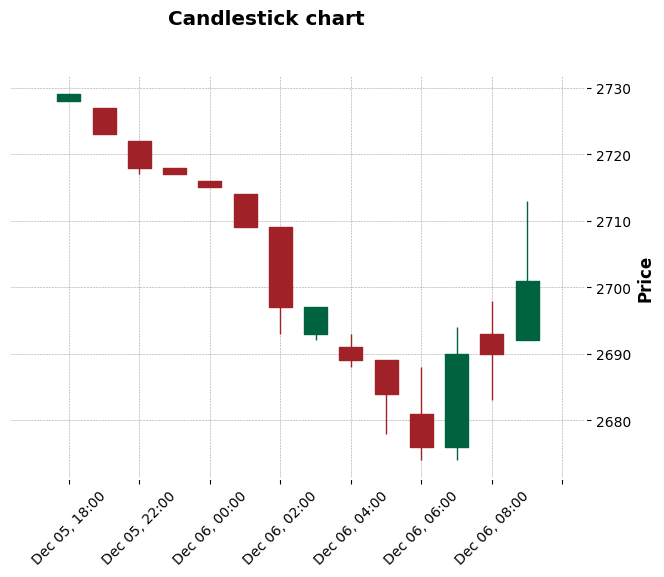

In [227]:
mpf.plot(data.iloc[:14], type='candle', style='charles', title='Candlestick chart', ylabel='Price', volume=False, show_nontrading=False)

## KMeans Clustering

In [228]:
features = data[['body_ratio', 'upper_shadow_ratio', 'lower_shadow_ratio', 'log_total_length']]
n_clusters = 175

data['cluster'] = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(features)

data.to_csv('../outputs/data_with_clusters.csv', index=True)

## Visualization candlestick chart with clusters

In [229]:
# Select part of the data for plotting

middle_data = data.iloc[545:580]

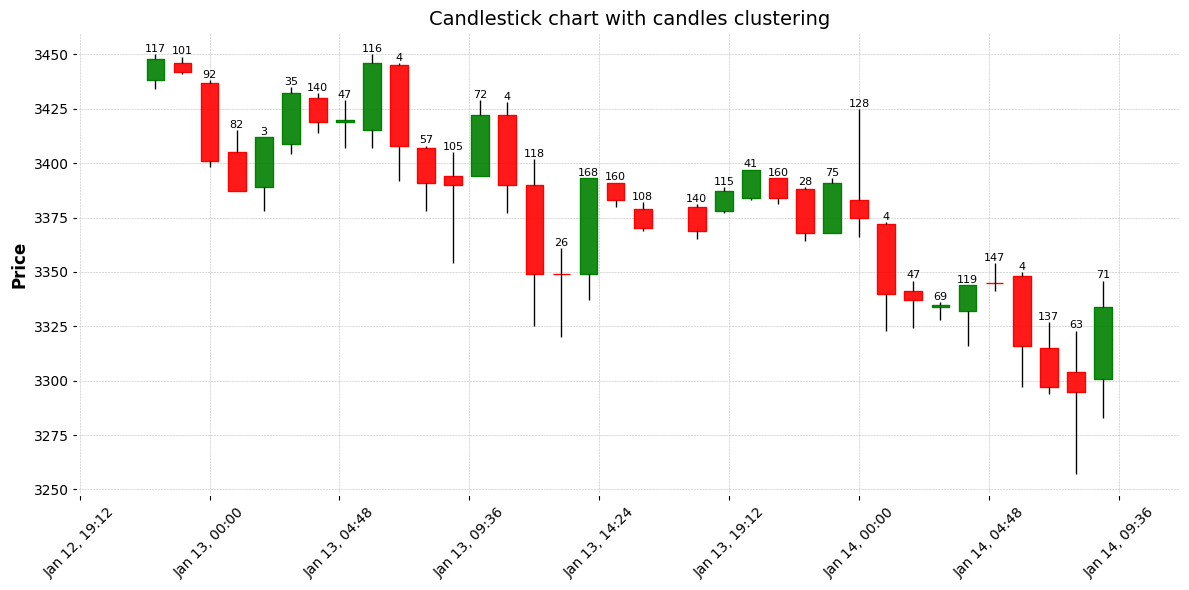

In [230]:
samples_per_cluster = [min(count, 7) for count in data.sort_values('cluster')['cluster'].value_counts().sort_index()]
cumulative_samples = list(itertools.accumulate(samples_per_cluster, initial=0))

# Configure color and graoh styles
mc = mpf.make_marketcolors(up='g', down='r', wick='black', edge='inherit')
s = mpf.make_mpf_style(marketcolors=mc)

# Plot a candlestick chart
fig, ax = plt.subplots(figsize=(12, 6))
mpf.plot(middle_data, type='candle', ax=ax, style=s, show_nontrading=True)
plt.grid(True, linestyle='--', alpha=0.7)

# Add labels for the new combined cluster
for i, row in middle_data.iterrows():
    ax.text(row.name, row['High'] + 0.1, int(row['cluster']), 
            fontsize=8, ha='center', va='bottom', color='black')

# Titles and labels
ax.set_title('Candlestick chart with candles clustering', fontsize=14)
ax.set_ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Reinforcement Learning

In [258]:
data = pd.read_csv('../outputs/data_with_clusters.csv')

# Q-learning parameters
clusters = data['cluster'].unique()
n_clusters = len(clusters)
actions = [0, 1, 2]            # 0=buy, 1=sell, 2=hold
n_actions = len(actions)

q_table = np.zeros((n_clusters, n_actions))

alpha = 0.1       # learning rate
gamma = 0.95      # discount factor
epsilon = 0.1    # exploration rate
min_epsilon = 0.01
decay_rate = 0.995
n_episodes = 2000
initial_cash = 10000

# Reward function
def get_reward(prev_portfolio, cash, shares, price):
    new_portfolio = cash + shares * price
    return new_portfolio - prev_portfolio

# Storage for metrics
episodes = []
final_cash_list = []
shares_remaining = []
action0_count = []
action1_count = []
action2_count = []

# Training loop
for ep in range(1, n_episodes + 1):
    cash = initial_cash
    shares = 0
    portfolio = initial_cash
    actions_taken = []

    for i in range(len(data) - 1):
        state = data.loc[i, 'cluster']
        next_state = data.loc[i + 1, 'cluster']
        price = data.loc[i, 'Close']
        next_price = data.loc[i + 1, 'Close']

        # ε-greedy action
        if random.random() < epsilon:
            a = random.choice(actions)
        else:
            a = np.argmax(q_table[state])
        actions_taken.append(a)

        prev_portfolio = portfolio

        # execute action
        if a == 0 and cash >= price:
            shares += 1
            cash -= price
        elif a == 1 and shares > 0:
            shares -= 1 
            cash += price
        # hold does nothing

        # reward amd Q-update
        portfolio = cash + shares * next_price
        reward = get_reward(prev_portfolio, cash, shares, next_price)

        old = q_table[state, a]
        q_table[state, a] = (1 - alpha) * old + alpha * (reward + gamma * q_table[next_state].max())

    # decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    final_cash = cash + shares * data.loc[len(data)-1, 'Close']
    cnt = Counter(actions_taken)

    # record metrics for this episode
    episodes.append(ep)
    final_cash_list.append(final_cash)
    shares_remaining.append(shares)
    action0_count.append(cnt.get(0, 0))
    action1_count.append(cnt.get(1, 0))
    action2_count.append(cnt.get(2, 0))

    # print summary for this episode
    print(f"Episode {ep}: Final Cash = {final_cash:.2f}, "
          f"Buy={cnt.get(0,0)}, Sell={cnt.get(1,0)}, Hold={cnt.get(2,0)}, "
          f"Shares Left={shares}")

Episode 1: Final Cash = 12603.00, Buy=719, Sell=620, Hold=408, Shares Left=2
Episode 2: Final Cash = 14954.00, Buy=500, Sell=744, Hold=503, Shares Left=0
Episode 3: Final Cash = 15629.00, Buy=514, Sell=696, Hold=537, Shares Left=2
Episode 4: Final Cash = 11745.00, Buy=490, Sell=766, Hold=491, Shares Left=0
Episode 5: Final Cash = 13183.00, Buy=475, Sell=786, Hold=486, Shares Left=0
Episode 6: Final Cash = 13101.00, Buy=505, Sell=816, Hold=426, Shares Left=0
Episode 7: Final Cash = 13942.00, Buy=512, Sell=849, Hold=386, Shares Left=0
Episode 8: Final Cash = 13236.00, Buy=504, Sell=868, Hold=375, Shares Left=0
Episode 9: Final Cash = 13016.00, Buy=506, Sell=870, Hold=371, Shares Left=0
Episode 10: Final Cash = 15587.00, Buy=501, Sell=865, Hold=381, Shares Left=0
Episode 11: Final Cash = 14480.00, Buy=486, Sell=898, Hold=363, Shares Left=1
Episode 12: Final Cash = 14700.00, Buy=485, Sell=890, Hold=372, Shares Left=0
Episode 13: Final Cash = 14569.00, Buy=494, Sell=884, Hold=369, Shares Le

In [259]:
# Optimal policy

# Get best action for each cluster from the Q-table
best_actions = np.argmax(q_table, axis=1)
data['best_action'] = data['cluster'].apply(lambda c: best_actions[c])

data.to_csv('../outputs/data_with_policy.csv', index=False)

## Plotting metrics

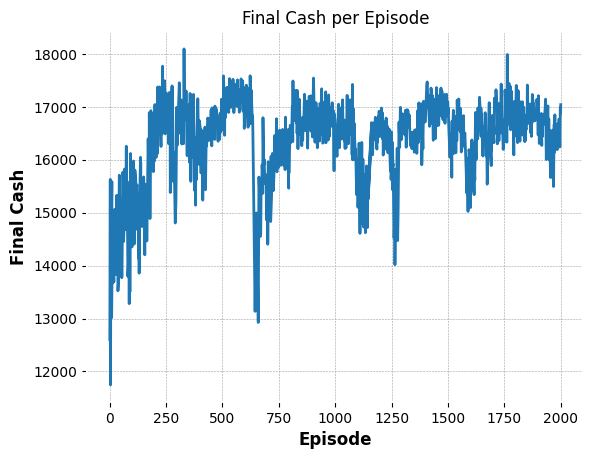

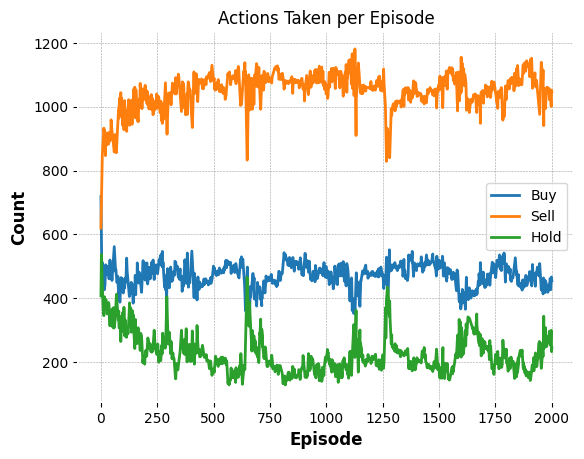

In [260]:
# Final cash over episodes
plt.figure()
plt.plot(episodes, final_cash_list)
plt.xlabel('Episode')
plt.ylabel('Final Cash')
plt.title('Final Cash per Episode')
plt.grid(True)
plt.show()

# Action counts per episode (three lines in one plot)
plt.figure()
plt.plot(episodes, action0_count, label='Buy')
plt.plot(episodes, action1_count, label='Sell')
plt.plot(episodes, action2_count, label='Hold')
plt.xlabel('Episode')
plt.ylabel('Count')
plt.title('Actions Taken per Episode')
plt.legend()
plt.grid(True)
plt.show()


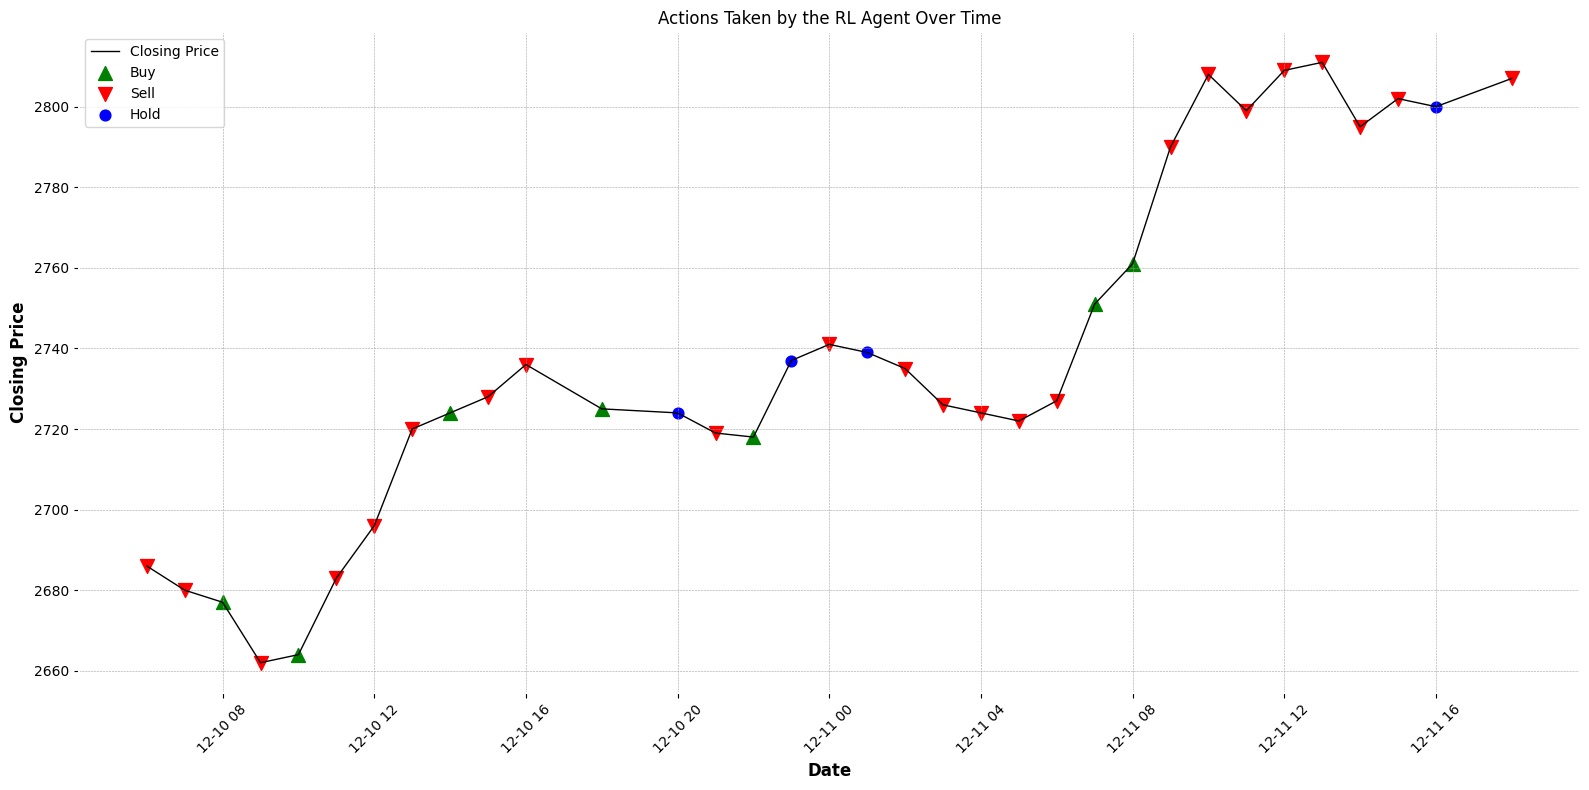

In [261]:
df = pd.read_csv('../outputs/data_with_policy.csv')

# Ensure the Date column is in datetime format (in case it's a string)
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[56:90]

# Plot closing prices
plt.figure(figsize=(16, 8))
plt.plot(df['Date'], df['Close'], label='Closing Price', color='black', linewidth=1)

# Mark actions with different colors
buy_signals = df[df['best_action'] == 0]
sell_signals = df[df['best_action'] == 1]
hold_signals = df[df['best_action'] == 2]

plt.scatter(buy_signals['Date'], buy_signals['Close'], label='Buy', marker='^', color='green', s=100)
plt.scatter(sell_signals['Date'], sell_signals['Close'], label='Sell', marker='v', color='red', s=100)
plt.scatter(hold_signals['Date'], hold_signals['Close'], label='Hold', marker='o', color='blue', s=60)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actions Taken by the RL Agent Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [262]:
cash = initial_cash
shares = 0
portfolio = initial_cash

for i in range(len(data) - 1):
    action = data.loc[i, 'best_action']
    price = data.loc[i, 'Close']

    # Execute action
    if action == 0 and cash >= price:
        shares += 1
        cash -= price
    elif action == 1 and shares > 0:
        shares -= 1
        cash += price
    # Hold does nothing

# If still holding shares at the end, sell at the last price
final_price = data.loc[len(data) - 1, 'Close']
cash += shares * final_price

total_reward = cash - initial_cash

print(f"Total Reward Following the Trained Policy: {total_reward:.2f}\nFinal Cash: {cash:.2f}\nShares Remaining: {shares}")

Total Reward Following the Trained Policy: 7095.00
Final Cash: 17095.00
Shares Remaining: 0
